In [1]:
%cd 'Q:\Dropbox\python\QSim\'

Q:\Dropbox\python\QSim


In [2]:
from scipy.io import *
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import ode

In [5]:
def cross(a, b):
    return [a[i]*b[i+1]-a[i+1]*b[i] for i in [1,-1,0]]

def jacobian(X):
    #J = [[(np.roll(X[i],-1,j)-np.roll(X[i],1,j))*0.5 for j in range(0,3)] for i in range(0,3)]
    J = [np.gradient(X[i], edge_order = 2) for i in range(0,3)]
    #for i in range(0,3):
    #    J[i][0][0,:,:] = -1.5*X[i][0,:,:]+2*X[i][1,:,:]-0.5*X[i][2,:,:]
    #    J[i][0][-1,:,:] = 1.5*X[i][-1,:,:]-2*X[i][-2,:,:]+0.5*X[i][-3,:,:]
    #    J[i][1][:,0,:] = -1.5*X[i][:,0,:]+2*X[i][:,1,:]-0.5*X[i][:,2,:]
    #    J[i][1][:,-1,:] = 1.5*X[i][:,-1,:]-2*X[i][:,-2,:]+0.5*X[i][:,-3,:]
    #    J[i][2][:,:,0] = -1.5*X[i][:,:,0]+2*X[i][:,:,1]-0.5*X[i][:,:,2]
    #    J[i][2][:,:,-1] = 1.5*X[i][:,:,-1]-2*X[i][:,:,-2]+0.5*X[i][:,:,-3]
    return J

def hessian(X):
    J = jacobian(X)   
    H = [[[(-2*X[i] + np.roll(X[i],-1,k)+np.roll(X[i],1,k)) if k == j else 
           (np.roll(J[i][j],-1,k)-np.roll(J[i][j],1,k))*0.5 for k in range(0,j+1)] for j in range(0,3)] for i in range(0,3)]
    
    for i in range(0,3):
        H[i][0][0][0,:,:] = 2*X[i][0,:,:]-5*X[i][1,:,:]+4*X[i][2,:,:]-X[i][3,:,:]
        H[i][0][0][-1,:,:] = 2*X[i][-1,:,:]-5*X[i][-2,:,:]+4*X[i][-3,:,:]-X[i][-4,:,:]
        H[i][1][1][:,0,:] = 2*X[i][:,0,:]-5*X[i][:,1,:]+4*X[i][:,2,:]-X[i][:,3,:]
        H[i][1][1][:,-1,:] = 2*X[i][:,-1,:]-5*X[i][:,-2,:]+4*X[i][:,-3,:]-X[i][:,-4,:]
        H[i][2][2][:,:,0] = 2*X[i][:,:,0]-5*X[i][:,:,1]+4*X[i][:,:,2]-X[i][:,:,3]
        H[i][2][2][:,:,-1] = 2*X[i][:,:,-1]-5*X[i][:,:,-2]+4*X[i][:,:,-3]-X[i][:,:,-4]
        
        for j in (1,2):
            H[i][j][0][0,:,:] = -1.5*J[i][j][0,:,:]+2*J[i][j][1,:,:]-0.5*J[i][j][2,:,:]
            H[i][j][0][-1,:,:] = 1.5*J[i][j][-1,:,:]-2*J[i][j][-2,:,:]+0.5*J[i][j][-3,:,:]
        
        H[i][2][1][:,0,:] = -1.5*J[i][2][:,0,:]+2*J[i][2][:,1,:]-0.5*J[i][2][:,2,:]
        H[i][2][1][:,-1,:] = 1.5*J[i][2][:,-1,:]-2*J[i][2][:,-2,:]+0.5*J[i][2][:,-3,:]        
    
    return (H, J)       

def det(a):
    return np.sum([a[0][i-1]*(a[1][i]*a[2][i+1]-a[1][i+1]*a[2][i]) for i in [1,-1,0]],0)

def rot(B, X):
    hes = hessian(X)
    J = hes[1]
    H = hes[0]
    detJ = det(J)
    Jb = [[(J[i][j]*J[i+1][j+1] - J[i+1][j]*J[i][j+1])/detJ for j in [-2,-1,0]] for i in [1,-1,0]]
    dB = [np.gradient(B[i], edge_order = 2) for i in range(0,3)]
    Bx = [np.sum([J[i][j]*B[j] for j in range(0,3)],0)/detJ for i in range(0,3)]
    
    #B2 = np.sum(np.power(B,2),0)
    #Bx2 = np.sum(np.power(Bx,2),0)
  
    #DdetJ = [det([[H[i][j][0],J[i][1],J[i][2]] for i in range(0,3)])+
    #        det([[J[i][0],H[i][max(j,1)][min(j,1)],J[i][2]] for i in range(0,3)])+
    #        det([[J[i][0],J[i][1],H[i][max(j,2)][min(j,2)]] for i in range(0,3)]) for j in range(0,3)]

    DdetJ = [np.sum([[H[i][max(j,k)][min(j,k)]*Jb[i][j] for i in range(0,3)] for j in range(0,3)],(0,1))*detJ for k in range(0,3)]    

    
    dBx = [[(np.sum([J[i][k]*dB[k][j] + H[i][max(k,j)][min(k,j)]*B[k] for k in range(0,3)],0) -
                DdetJ[j]*Bx[i])/detJ for j in range(0,3)] for i in range(0,3)]
    
    #rotB = [np.sum([Jb[i][j]*dBx[i+1][j]-Jb[i+1][j]*dBx[i][j] for j in range(0,3)],0) for i in [1,-1,0]]
    
    force = [np.sum([B[j]*dBx[i][j]/detJ - np.sum([Bx[k]*dBx[k][j] for k in range(0,3)],0)*Jb[i][j]
                     for j in range(0,3)],0) for i in range(0,3)]
    
    #b = [np.sum([B[j]*dBx[i][j]/detJ for j in range(0,3)],0) for i in range(0,3)]
    #c = [np.sum([Bx[j]*dBx[j][i] for j in range(0,3)],0)  for i in range(0,3)]
    
    
    #q = [np.sum([(B2/detJ**2*(i == j) - Bx[i]*np.sum([Jb[k][j]*B[k] for k in range(0,3)],0)/detJ - 
    #      Bx[j]*np.sum([Jb[k][i]*B[k] for k in range(0,3)],0)/detJ + 
    #      Bx2*np.sum([Jb[k][i]*Jb[k][j] for k in range(0,3)],0))*X[j]
    #      for j in range(0,3)],0) for i in range(0,3)]
    
    return force

def force(B, X):
    ## from Craig & Sneyd (1986)
    dB = [np.gradient(B[i], edge_order = 2) for i in range(0,3)]
    hes = hessian(X)
    J = hes[1]
    H = hes[0]
    detJ = det(J)
    detJ2 = detJ**2
    Jb = [[(J[i][j]*J[i+1][j+1] - J[i+1][j]*J[i][j+1])/detJ for j in [-2,-1,0]] for i in [1,-1,0]]
    b = [np.sum([J[i][j]*B[j] for j in range(0,3)],0) for i in range(0,3)]
    b2 = np.sum(np.power(b,2),0)
    g = [[1 if i==j else 0 for j in range(0,3)] for i in range(0,3)]
    
    A = [[[[(g[i][j]*B[k]*B[l] - (b[i]*Jb[j][k]+b[j]*Jb[i][k])*B[l] + b2*Jb[l][i]*Jb[j][k])/detJ2
            for l in range(0,3)] for k in range(0,3)] for j in range(0,3)] for i in range(0,3)]
    
    C = [(np.sum([np.sum([B[k]*dB[j][k] for k in range(0,3)],0)*J[i][j] for j in range(0,3)],0) -
         np.sum([np.sum([np.sum([J[k][l]*dB[l][j] for l in range(0,3)],0)*b[k] for k in range(0,3)],0)*Jb[i][j]
                 for j in range(0,3)],0))/detJ2
         for i in range(0,3)]
    
    return [np.sum([np.sum([np.sum([A[i][j][k][l]*H[j][max(k,l)][min(k,l)] for l in range(0,3)],0)
                            for k in range(0,3)],0) for j in range(0,3)],0) + C[i] for i in range(0,3)]


In [16]:
dim = [64,64,64]
X = np.mgrid[0:dim[0], 0:dim[1], 0:dim[2]].astype(np.float64)
xsh = X.shape
B = [np.zeros(dim) for i in range(0,3)]
B[2] = np.ones(dim)
X1 = np.array(X)
ar = 16**2
az = 32
h = np.exp(-((X[0]-dim[0]/2)**2 + (X[1]-dim[1]/2)**2)/ar - X[2]/az)*np.pi/4

#h = np.exp(-((X[0]-dim[0]/2)**2 + (X[1]-dim[1]/2)**2)/ar)*X[2]/dim[2]*np.pi/4

X[0] = (X1[0]-dim[0]/2)*np.cos(h) - (X1[1]-dim[1]/2)*np.sin(h) + dim[0]/2
X[1] = (X1[0]-dim[0]/2)*np.sin(h) + (X1[1]-dim[1]/2)*np.cos(h) + dim[1]/2


#X[0][20:40,20:40,0] = X[0][20:40,20:40,0] + np.random.rand(20,20)*0.9
#X[1][20:40,20:40,0] = X[1][20:40,20:40,0] + np.random.rand(20,20)*0.9

#X[1] = X[1] + (X[0]-dim[0]/2)*np.exp(-np.abs(X[0]-dim[0]/2)/2)*np.cos(np.pi*X[2]/dim[2])

X1 = np.array(X)

In [7]:


def f(t,y):
    y.shape = xsh
    f = np.array(rot(B,y))*1e-2
    f[:,:,:,0] = 0
    f[:,:,:,-1] = 0
    return f.flatten()

r = ode(f).set_integrator('dop853').set_initial_value(X1.flatten(),0)

dt = 1

while r.t < 1000 and r.successful():
    Y = np.array(r.integrate(r.t+dt))
    Y.shape = xsh
    
    fig = plt.figure(0,[8,8])
    ax = fig.add_subplot(111, projection='3d')
    for i in range(24,40,2):
        for j in range(24,40,2):
            ax.plot(Y[0][i,j,:],Y[1][i,j,:],Y[2][i,j,:], color = 'green')
    plt.savefig('img/img'+str(np.floor(r.t).astype(np.int32)))
    
    print r.t, np.max(np.abs(rot(B,Y)))




1.0 0.99458055309


KeyboardInterrupt: 

In [18]:
X = np.array(X1)

step = 1e-1
for i in range(0,100):
    F1 = np.array(rot(B,X))
    F2 = np.array(rot(B,X+F1*step*0.5))
    F3 = np.array(rot(B,X+F2*step*0.5))
    F4 = np.array(rot(B,X+F3*step))
    
    F = (F1+2*F2+2*F3+F4)/6
    F[:,:,:,0] = 0
    F[:,:,:,-1] = 0
    X += F*step
    print np.max(np.abs(F))

0.00611273449422
0.00579196643366
0.00569692522691
0.00557287231328
0.00548494554167
0.00544230492005
0.00539256647496
0.00533680733882
0.00527615167345
0.00521167146876
0.00515253297599
0.00512145020103
0.0050885294914
0.00505567115346
0.00502111126887
0.00498506702025
0.00494774973181
0.00490936047631
0.00487008730591
0.00483157625739
0.00480896460353
0.00478560618793
0.00476156336299
0.00473689866029
0.00471167383731
0.00468648316471
0.00466212760972
0.00463736737758
0.00461225437997
0.00458683771397
0.00456116357043
0.0045352752066
0.00451598458053
0.00449917841048
0.00448210069931
0.00446477254825
0.00444721460302
0.00442944696202
0.00441148910461
0.00439335983676
0.00437507725159
0.00435748071109
0.00434029309516
0.00432298686525
0.00430557687723
0.00428807725968
0.00427050142449
0.00425286208108
0.00423919203561
0.00422687363094
0.00421478189795
0.00420326788858
0.00419165377538
0.00417994668144
0.00416815352507
0.00415628101426
0.00414433564282
0.00413232368809
0.00412025121004

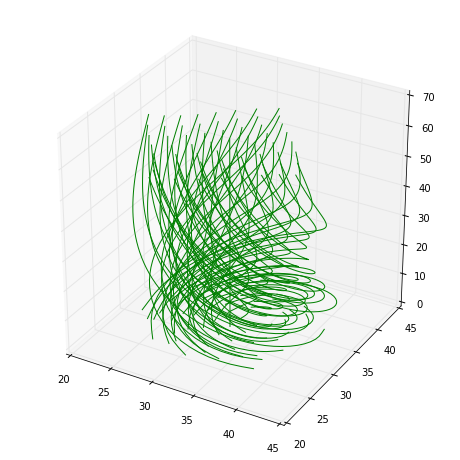

In [15]:
%matplotlib inline

fig = plt.figure(0,[8,8])
ax = fig.add_subplot(111, projection='3d')
for i in range(24,40,2):
    for j in range(24,40,2):
        ax.plot(X[0][i,j,:],X[1][i,j,:],X[2][i,j,:], color = 'green')
plt.show()



In [89]:
def f(t,y):
    return 1/y

r = ode(f).set_integrator('dop853').set_initial_value([[1,2],[3,4]],0)
Y = r.integrate(100)

r.successful()

False

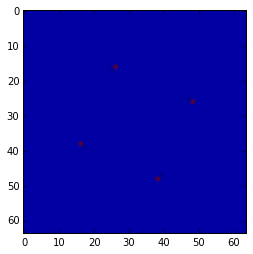

In [26]:
%matplotlib inline
plt.imshow(X[2][:,:,1])

In [28]:
np.min(X[2][:,:,1])

-22034.555557331943